# Crop Recommendation
With the current climate change, choosing the right crop for soil characteristic becomes hard task for framers.
This project aims to help farmers with that task, choosing the right crop for given soil characteristics.
To do that we can use Machine Learning Algorithms that allow us to create models capable of making predictions, in this case, predicting the right crop!

## Imports
First we need to know what we are working it! So let's import the necessary libraries that will allow us to train machine learning models.
- **numpy** - some data operations need the advanced library **numpy**;
- **Pandas** - to load and manipulate the dataset we must use Pandas DataFrame objects!
- **matplotlib** - as you might know, this library is essential for creating graphs in python, and we need to create them!
- **seaborn** - this library allows us to have a higher level interface for **matplotlib**;
- **Scikit Learn (sklearn)** - contains the majority of the machine learning models, metrics, preprocessing functions and other important functions such as train-split of data and feature selection techniques;
- **time** - to know how much time a function took to fully execute we need this library; 
- **xgboost** - to use XGBoost algorithm we need this library!
- **lightgbm** - to use LightGBM algorithm we need this library!

We also need:
- **os** - this library allow us to interact with operative system API;
- **pathlib** - to better control the path of files and directories we need this library
- **math** - use ceil and floor functions to min and max values of each feature;
- **json** - allows us to export python dictionary as JSON text; 
- **skops** - this library allows us to export the model to a file and use it on REST APIs or other apps;

In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import clone
from xgboost.sklearn import XGBClassifier, XGBRFClassifier
from lightgbm.sklearn import LGBMClassifier

# Model persistence
import os
from pathlib import Path
import math
import json
from skops.io import dump as save_model_as_file

# For extra code
from sklearn import tree

## Read dataset CSV to DataFrame
Load the target crops dataset to an CSV and separate features from target feature/class

`crops_df` - DataFrame that will contain all crops features data, (except the target feature / class);
`crops_labels` - Series that will contain only the target feature / class;
`ordered_labels` - Numpy array that contains alphabetically ordered all the labels of the dataset.

In [254]:
csv_df = pd.read_csv("../Data/Clean/Manikanta_CR.csv")

print(csv_df.head())

crops_df = csv_df.drop("label", axis=1)
crops_labels = csv_df["label"]
ordered_labels = np.unique(crops_labels.unique().tolist())

     N   P    K   ph    EC     S     Cu      Fe     Mn     Zn      B  \
0  143  69  217  5.9  0.58  0.23  10.20  116.35  59.96  54.85  21.29   
1  170  36  216  5.9  0.15  0.28  15.69  114.20  56.87  31.28  28.62   
2  158  66  219  6.8  0.34  0.20  15.29   65.87  51.81  57.12  27.59   
3  133  45  207  6.4  0.94  0.21   8.48  103.10  43.81  68.50  47.29   
4  132  48  218  6.7  0.54  0.19   5.59   63.40  56.40  46.71  31.04   

         label  
0  pomegranate  
1  pomegranate  
2  pomegranate  
3  pomegranate  
4  pomegranate  


## Split data
Split crops data (default: 75/25) into four sets:
- `x_train` -> crops features data to train algorithms;
- `x_text` -> crops features data to test generated models;
- `y_train` -> crops target feature to train algorithms (follows the same order `x_train`);
- `y_test` -> crops target feature to test generated models (follows the same order `x_test`);

In [255]:
split_random_state = 420
split_percentage = 0.25 # 1 - this value = training data size

x_train, x_test, y_train, y_test = train_test_split(crops_df, crops_labels, test_size=split_percentage, random_state=split_random_state)

print(f"Training size: {len(x_train)} ({len(x_train)/len(csv_df)*100}%)\nTest size: {len(x_test)} ({len(x_test)/len(csv_df)*100}%)\n")

Training size: 463 (74.91909385113269%)
Test size: 155 (25.080906148867317%)


## Data preprocessing
This notebook does not preprocess the data in ways that it removes the outliers, duplicates and/or instances with null values. Thus, the given dataset must already be preprocessed.
The following preprocessing only scales features values and encodes labels because of certain algorithms that require it. 

### Scale data

As you might know, some algorithms (such as Logistic Regression and Neural Networks) need features values to be scaled/normalized. Because of this two new dataframes were created:
- `scaled_x_train` - scaled crops features data to train algorithms;
- `scaled_x_text` - scaled crops features data to test generated models;

In [256]:
scaler = StandardScaler()
scaled_x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
scaled_x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

## Label encoder
Since XGBoost needs label encoding, let's create new versions of `y_train` and `y_test` that are encoded (`encoded_y_train` and `encoded_y_test`).

In [257]:
label_encoder = LabelEncoder()
encoded_y_train = pd.Series(label_encoder.fit_transform(y_train), name="label")
encoded_y_test = pd.Series(label_encoder.transform(y_test), name="label")

## Crops classes distribution
Since crop recommendation is a multiclass problem, let's visualize which classes exits and how many instances exist for each one of them.
If the dataset shows an imbalance of classes, the training process must be adjusted to fit with weights.

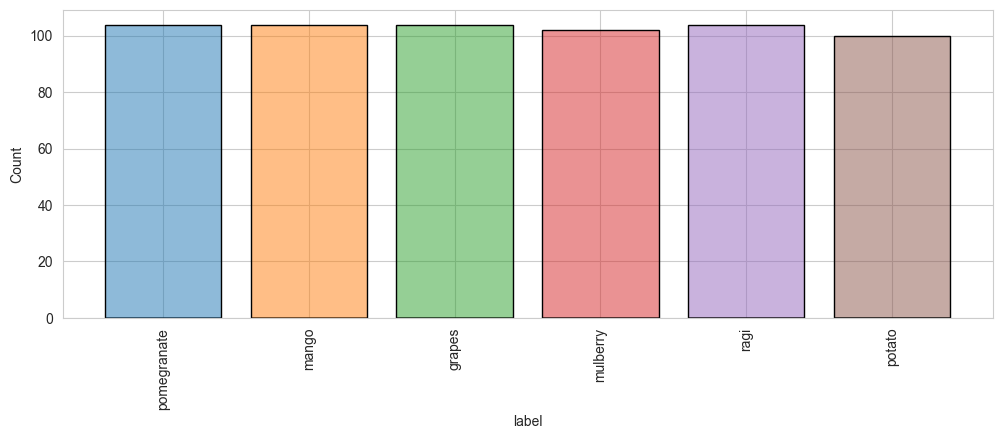

In [258]:
plt.figure(figsize=(12,4))
csv_labels_hist = sns.histplot(csv_df, x="label", hue="label", edgecolor="black", shrink=0.8)
plt.legend([],[], frameon=False) # Remove legend from histplot, source https://stackoverflow.com/questions/54781243/hide-legend-from-seaborn-pairplot
csv_labels_hist.set(xlabel="label", ylabel="Count")
csv_labels_hist.tick_params(axis="x", rotation=90)

## Feature correlation
For the given dataset let's create feature correlation matrix.
This correlation matrix helps us with the visualization of features that relate better to each other, thus allowing us to identify redundant information if the correlation is very high (1 or -1).

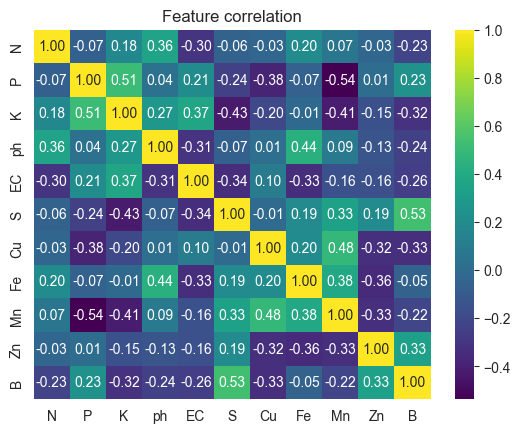

In [259]:
corr_matrix = sns.heatmap(crops_df.corr(), annot=True, fmt=".2f", cmap="viridis")
corr_matrix.set_title("Feature correlation")

plt.show()

## Feature selection
Select the best features of the dataset with the objective to only use the best ones.
Creates a dictionary `selected_features` that each key corresponds to the used method followed with the abbreviation of the estimator (if used), ex: `RFECV_RF` = `RFECV with Random Forest`

Methods employed for the first project:
1. RFCEV;
2. Model;

The two algorithms chosen for choosen for the first project are:
1. Random Forest;
2. Support Vector Classifier (SVM family);

In future others algorithms may be considered as well

`s_random_state` - random value seed to ensure that results of reruns are the same
`og_selected_features` - dictionary to save all feature selection methods without duplication check

In [260]:
fs_random_state = 2024
og_selected_features = {}

### RFECV
Selects features with the Recursive feature elimination with cross validation method. This method is almost the same as the famous wrapper method (mlxtend - SequentialFeatureSelector)
#### Random Forest

In [261]:
rfecv_rf = RFECV(RandomForestClassifier(n_jobs=-1, random_state=fs_random_state), n_jobs=-1)
rfecv_rf.fit(x_train, y_train)

og_selected_features["RFECV_RF"] = rfecv_rf.get_feature_names_out()
print(f"Selected features: {rfecv_rf.get_feature_names_out()}")

Selected features: ['N' 'P' 'K' 'ph' 'EC' 'S' 'Fe' 'Mn' 'Zn' 'B']


#### Suppor Vector Classifier

In [262]:
rfecv_svc = RFECV(SVC(random_state=fs_random_state, kernel="linear"), n_jobs=-1)
rfecv_svc.fit(scaled_x_train, y_train)

og_selected_features["RFECV_SVC"] = rfecv_svc.get_feature_names_out()
print(f"Selected features: {rfecv_svc.get_feature_names_out()}")

Selected features: ['N' 'P' 'K' 'ph' 'EC' 'S' 'Fe' 'Mn' 'Zn' 'B']


### SelectFromModel
Selects the best features based on weights that are discovered and given by the algorithm

#### Random Forest

In [263]:
selectModel_rf = SelectFromModel(RandomForestClassifier(random_state=fs_random_state))
selectModel_rf.fit(x_train, y_train)

og_selected_features["MODEL_RF"] = selectModel_rf.get_feature_names_out()
print(f"Selected features: {selectModel_rf.get_feature_names_out()}")

Selected features: ['K' 'EC' 'S' 'Fe' 'Mn' 'B']


#### Suppor Vector Classifier

In [264]:
selectModel_svc = SelectFromModel(SVC(random_state=fs_random_state, kernel="linear"))
selectModel_svc.fit(scaled_x_train, y_train)

og_selected_features["MODEL_SVC"] = selectModel_svc.get_feature_names_out()
print(f"Selected features: {selectModel_svc.get_feature_names_out()}")

Selected features: ['K' 'EC' 'S' 'Fe' 'Mn' 'B']


### Clean dictionary of selected features
Joins feature selections that are the same. So it doesn't train algorithms with the same features more than once.
Include all features too, because they are an option too!
Creates `selected_features` that will be used in the training process.

In [265]:
selected_features = {"ALL": crops_df.columns.to_numpy()}

for og_name, og_features in og_selected_features.items():
    found_name = None
    for name, features in selected_features.items():
        if np.array_equal(og_features, features):
            found_name = name
            break
    
    if found_name is not None:
        selected_features[f"{found_name}-{og_name}"] = selected_features.pop(found_name)
    else:
        selected_features[og_name] = og_features

for name, features in selected_features.items():
    print(f"{name} - {features}")

ALL - ['N' 'P' 'K' 'ph' 'EC' 'S' 'Cu' 'Fe' 'Mn' 'Zn' 'B']
RFECV_RF-RFECV_SVC - ['N' 'P' 'K' 'ph' 'EC' 'S' 'Fe' 'Mn' 'Zn' 'B']
MODEL_RF-MODEL_SVC - ['K' 'EC' 'S' 'Fe' 'Mn' 'B']


## Model training/validation
Now, let's define all the ML (Machine Learning) algorithms that will be trained with the data.
Additionally let's create a dictionary with the full names of algorithms (`fill_name_algorithms`), tuple with the keys of algorithms that need the data of features scaled (`need_scale`) and tuple with the keys of algorithms that need the class (target feature / label) encoded in numbers (`need_class_encode`)

Also let's define a random seed (`m_random_state`) so we can compare the "same models" on different features.

**IMPORTANT**: In a first phase of my project, hyperparameter tuning isn't taken in consideration. The reason behind this choice is to verify how well models produced by algorithms with default params perform for this given problem (crop recommendation). 

In [266]:
training_random_state = 1374

full_name_algorithms = {
    "DT": "Decision Tree",
    "RF": "Random Forest",
    "NB": "Naïve Bayes",
    "XGB": "XGBoost",
    "XGBRF": "XGBoost (with Random Forest)",
    "LGBM": "LightGBM",
    "KNN": "K Nearest Neighbors",
    "LoR": "Logistic Regression",
    "SVC": "Support Vector Classifier",
    "MLPNN": "Neural Network (Multi-layer Perceptron)"
}

need_scale = ("KNN", "LoR", "SVC", "MLPNN")
need_class_encode = ("XGB", "XGBRF")

algorithms = {
    "DT": DecisionTreeClassifier(random_state=training_random_state),
    "RF": RandomForestClassifier(random_state=training_random_state, n_jobs=-1),
    "NB": MultinomialNB(),
    "XGB": XGBClassifier(random_state=training_random_state, n_jobs=-1),
    "XGBRF": XGBRFClassifier(random_state=training_random_state, n_jobs=-1),
    "LGBM": LGBMClassifier(random_state=training_random_state, n_jobs=-1, verbose=-1),
    "KNN": KNeighborsClassifier(n_jobs=-1),
    "LoR": LogisticRegression(max_iter=500, random_state=training_random_state, n_jobs=-1),
    "SVC": SVC(random_state=training_random_state),
    "MLPNN": MLPClassifier(random_state=training_random_state, max_iter=1000),
}

### Function to produce evaluation scores (train/test method)
Define function that returns the metrics of a given predictions and real values

Used metrics:
- Accuracy;
- Precision;
- Recall;
- F1-Score.

In [282]:
def score_model(y_pred, y_test) -> dict:
    return {
        "accuracy": round(accuracy_score(y_test, y_pred), 6),
        "precision": round(precision_score(y_test, y_pred, average="macro"), 6),
        "recall": round(recall_score(y_test, y_pred, average="macro"), 6),
        "f1": round(f1_score(y_test, y_pred, average="macro"), 6),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

### Train/Test split training
Firstly we will do the traditional approach, let's train and test models on two data splits (train and test)! This allows us to verify how well a model performs on unseen data, **but attention** the test data can contain important data that allow us to predict better a certain class.

For Train/Test split training we will save all the results on  `tt_results` dictionary where first level key is the feature set name.

In [283]:
tt_results = {}

for name, features in selected_features.items():
    print(f"\nInitialized training process on {name} ({features})")
    
    tt_results[name] = { "features": features }
    for key, algorithm in algorithms.items():
        model = clone(algorithm)
        
        start = time.time()
        if key in need_scale:
            _x_train = scaled_x_train[features]
            _x_test = scaled_x_test[features]
        else:
            _x_train = x_train[features]
            _x_test = x_test[features]
            
        if key in need_class_encode:
            _y_train = encoded_y_train
            _y_test = encoded_y_test
        else:
            _y_train = y_train
            _y_test = y_test
            
        model.fit(_x_train, _y_train)
        y_pred = model.predict(_x_test)
            
        duration = round(time.time()-start, 4)
        
        print(f"\t{key} trained in {duration}ms")
        
        tt_results[name][key] = score_model(y_pred, _y_test) | { "model": model }
        


Initialized training process on ALL (['N' 'P' 'K' 'ph' 'EC' 'S' 'Cu' 'Fe' 'Mn' 'Zn' 'B'])
	DT trained in 0.0061ms
	RF trained in 0.134ms
	NB trained in 0.0025ms
	XGB trained in 0.0907ms
	XGBRF trained in 0.1603ms
	LGBM trained in 0.252ms
	KNN trained in 0.0276ms
	LoR trained in 0.4257ms
	SVC trained in 0.0062ms
	MLPNN trained in 0.7513ms

Initialized training process on RFECV_RF-RFECV_SVC (['N' 'P' 'K' 'ph' 'EC' 'S' 'Fe' 'Mn' 'Zn' 'B'])
	DT trained in 0.005ms
	RF trained in 0.1341ms
	NB trained in 0.003ms
	XGB trained in 0.0947ms
	XGBRF trained in 0.2299ms
	LGBM trained in 0.2299ms
	KNN trained in 0.167ms
	LoR trained in 0.415ms
	SVC trained in 0.006ms
	MLPNN trained in 0.674ms

Initialized training process on MODEL_RF-MODEL_SVC (['K' 'EC' 'S' 'Fe' 'Mn' 'B'])
	DT trained in 0.004ms
	RF trained in 0.1258ms
	NB trained in 0.003ms
	XGB trained in 0.0956ms
	XGBRF trained in 0.1502ms
	LGBM trained in 0.1872ms
	KNN trained in 0.025ms
	LoR trained in 0.4248ms
	SVC trained in 0.0055ms
	MLPNN 

### Cross validate algorithms
Since the traditional approach of train/test split doesn't train models leave some data for testing (evaluate) models, we can't be sure if with the test data as training the models would have the same performance. Cross validations let's use divide the data in K folds, train models on each fold and evaluate it. This approach might allow us to verify which algorithm better "understands" the data with the average of the evaluation (metric needs to be choosen, can be accuracy, recall, precision or f1) of each model.
**IMPORTANT**: Cross validation is the best approach for when we have a very limited amount of data!

In [279]:
cv_results = {}

for name, features in selected_features.items():
    cv_results[name] = { "features": features }
    
    print(f"\nInitialized cross validation process on {name} ({features})")
    for key, algorithm in algorithms.items():
        if key in need_scale:
            _x = pd.concat([scaled_x_train, scaled_x_test])
        else:
            _x = pd.concat([x_train, x_test])
        
        if key in need_class_encode:
            _y = pd.concat([encoded_y_train, encoded_y_test])
        else:
            _y = pd.concat([y_train, y_test])
        
        start = time.time()
        model = clone(algorithm)
        cv_score = cross_val_score(model, _x[features], _y, n_jobs=-1, scoring="f1_macro")
        duration = round(time.time()-start, 4)
        
        print(f"\t{key} validated in {duration}ms")
        
        cv_results[name][key] = {
            "mean": round(cv_score.mean(), 6),
            "std": cv_score.std(),
            "model": model
        }


Initialized cross validation process on ALL (['N' 'P' 'K' 'ph' 'EC' 'S' 'Cu' 'Fe' 'Mn' 'Zn' 'B'])
	DT validated in 1.8832ms
	RF validated in 1.1967ms
	NB validated in 1.4034ms
	XGB validated in 1.0813ms
	XGBRF validated in 0.2984ms
	LGBM validated in 1.8102ms
	KNN validated in 0.1078ms
	LoR validated in 0.0647ms
	SVC validated in 0.0548ms
	MLPNN validated in 1.1503ms

Initialized cross validation process on RFECV_RF-RFECV_SVC (['N' 'P' 'K' 'ph' 'EC' 'S' 'Fe' 'Mn' 'Zn' 'B'])
	DT validated in 0.024ms
	RF validated in 0.2515ms
	NB validated in 0.0233ms
	XGB validated in 0.1103ms
	XGBRF validated in 0.2529ms
	LGBM validated in 0.9404ms
	KNN validated in 0.0461ms
	LoR validated in 0.0356ms
	SVC validated in 0.0455ms
	MLPNN validated in 0.8984ms

Initialized cross validation process on MODEL_RF-MODEL_SVC (['K' 'EC' 'S' 'Fe' 'Mn' 'B'])
	DT validated in 0.014ms
	RF validated in 0.2171ms
	NB validated in 0.014ms
	XGB validated in 0.0869ms
	XGBRF validated in 0.1809ms
	LGBM validated in 0.9207m

## Results
After training every single model it is essential to select the best one that will help us in the crop recommendation task.
In this section we will visualize the statistics of train/test split training and cross validation process, so after we can filter the best one (algorithm) for the problem and train a last model on all data to use in a real world app or REST API. 

### Train/Test split

In [284]:
pd.DataFrame.from_dict(tt_results)

,ALL,RFECV_RF-RFECV_SVC,MODEL_RF-MODEL_SVC
features,"[N, P, K, ph, EC, S, Cu, Fe, Mn, Zn, B]","[N, P, K, ph, EC, S, Fe, Mn, Zn, B]","[K, EC, S, Fe, Mn, B]"
DT,"{'accuracy': 0.941935, 'precision': 0.941118, ...","{'accuracy': 0.941935, 'precision': 0.941118, ...","{'accuracy': 0.935484, 'precision': 0.936246, ..."
RF,"{'accuracy': 0.974194, 'precision': 0.972912, ...","{'accuracy': 0.974194, 'precision': 0.972912, ...","{'accuracy': 0.967742, 'precision': 0.967357, ..."
NB,"{'accuracy': 0.941935, 'precision': 0.946004, ...","{'accuracy': 0.941935, 'precision': 0.946004, ...","{'accuracy': 0.896774, 'precision': 0.909792, ..."
XGB,"{'accuracy': 0.96129, 'precision': 0.960499, '...","{'accuracy': 0.974194, 'precision': 0.972912, ...","{'accuracy': 0.96129, 'precision': 0.960499, '..."
XGBRF,"{'accuracy': 0.96129, 'precision': 0.960293, '...","{'accuracy': 0.974194, 'precision': 0.972912, ...","{'accuracy': 0.974194, 'precision': 0.972912, ..."
LGBM,"{'accuracy': 0.96129, 'precision': 0.960499, '...","{'accuracy': 0.96129, 'precision': 0.960499, '...","{'accuracy': 0.96129, 'precision': 0.960499, '..."
KNN,"{'accuracy': 0.974194, 'precision': 0.972912, ...","{'accuracy': 0.974194, 'precision': 0.972912, ...","{'accuracy': 0.967742, 'precision': 0.967136, ..."
LoR,"{'accuracy': 0.967742, 'precision': 0.96737, '...","{'accuracy': 0.96129, 'precision': 0.961294, '...","{'accuracy': 0.974194, 'precision': 0.972912, ..."
SVC,"{'accuracy': 0.974194, 'precision': 0.972912, ...","{'accuracy': 0.974194, 'precision': 0.972912, ...","{'accuracy': 0.974194, 'precision': 0.972912, ..."


#### Confusion matrix
To see which labels the model has a more difficult time to correctly predict, we can use the Confusion Matrix that shows which classes the model has a bigger problem in differentiating.
In `cf_matrix` you can change which confusion matrix will be shown.

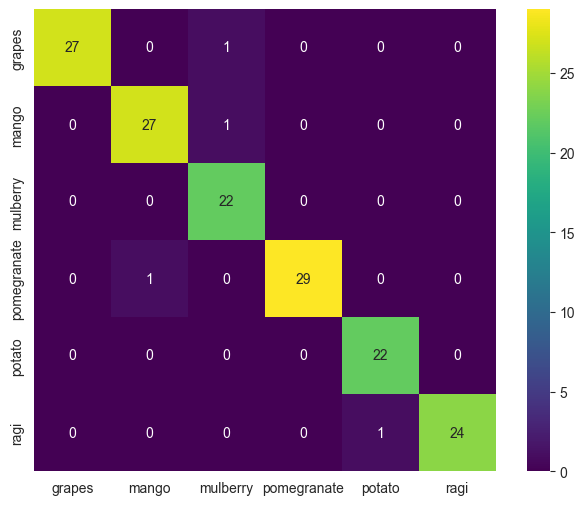

In [291]:
cf_matrix = tt_results["ALL"]["RF"]["confusion_matrix"]

plt.figure(figsize=(8,6))
ax = sns.heatmap(cf_matrix, annot=True, cmap="viridis", square=True, xticklabels=ordered_labels, yticklabels=ordered_labels)

plt.show()

### Cross validation

In [281]:
pd.DataFrame().from_dict(cv_results)

,ALL,RFECV_RF-RFECV_SVC,MODEL_RF-MODEL_SVC
features,"[N, P, K, ph, EC, S, Cu, Fe, Mn, Zn, B]","[N, P, K, ph, EC, S, Fe, Mn, Zn, B]","[K, EC, S, Fe, Mn, B]"
DT,"{'mean': 93.7185, 'std': 2.835777208955912, 'm...","{'mean': 94.9995, 'std': 2.1069046967450635, '...","{'mean': 93.8518, 'std': 1.8427533597823558, '..."
RF,"{'mean': 96.7627, 'std': 2.0979301386696387, '...","{'mean': 96.7627, 'std': 2.0979301386696387, '...","{'mean': 96.602, 'std': 2.0584608006613436, 'm..."
NB,"{'mean': 92.4331, 'std': 1.176360294537144, 'm...","{'mean': 91.94250000000001, 'std': 1.406871867...","{'mean': 87.1408, 'std': 3.7851002773721305, '..."
XGB,"{'mean': 96.59649999999999, 'std': 1.583881676...","{'mean': 96.7553, 'std': 1.7092398462022849, '...","{'mean': 96.276, 'std': 1.7351911855284075, 'm..."
XGBRF,"{'mean': 96.9182, 'std': 1.8853357816023777, '...","{'mean': 96.9182, 'std': 1.8853357816023777, '...","{'mean': 96.922, 'std': 1.4923738769618127, 'm..."
LGBM,"{'mean': 95.1661, 'std': 2.345932458746323, 'm...","{'mean': 95.1661, 'std': 2.345932458746323, 'm...","{'mean': 96.28989999999999, 'std': 2.548242645..."
KNN,"{'mean': 96.7545, 'std': 1.3591125693476869, '...","{'mean': 96.7545, 'std': 1.3591125693476869, '...","{'mean': 96.4145, 'std': 1.8980067732224197, '..."
LoR,"{'mean': 96.272, 'std': 1.5058522072743818, 'm...","{'mean': 96.4349, 'std': 1.5036676675409495, '...","{'mean': 96.5879, 'std': 1.5743770063469549, '..."
SVC,"{'mean': 97.0809, 'std': 1.671908414352737, 'm...","{'mean': 97.0809, 'std': 1.671908414352737, 'm...","{'mean': 96.7433, 'std': 1.7802287197252815, '..."


### Filter best models based on F1-Score
As said before, we need to choose the select the best model, the following blocks of code will filter the best model for each feature set based on **F1-Score** that better fits this crop recommendation problem. First we will filter the best for train/test split and after for cross validation.

#### Train/Test Split

In [273]:
tt_best_models = {}

for feature_set_name in selected_features:
    algo_abbreviation, metrics = list(tt_results[feature_set_name].items())[1]
    tt_best_models[feature_set_name] = (algo_abbreviation, metrics["f1"])
    
    for algo_abbreviation, metrics in list(tt_results[feature_set_name].items())[2:]: # skip "features" key and first model because it's the best one at start
        if metrics["f1"] > tt_best_models[feature_set_name][1]:
            tt_best_models[feature_set_name] = (algo_abbreviation, metrics["f1"])
        pass

print(tt_best_models)

{'ALL': ('RF', 97.38), 'RFECV_RF-RFECV_SVC': ('RF', 97.38), 'MODEL_RF-MODEL_SVC': ('XGBRF', 97.38)}


#### Cross validation

In [274]:
cv_best_models = {}

for feature_set_name in selected_features:
    f_algo_abbreviation, f_metrics = list(cv_results[feature_set_name].items())[1]
    cv_best_models[feature_set_name] = [f_algo_abbreviation, f_metrics["mean"]]
    
    for algo_abbreviation, metrics in list(cv_results[feature_set_name].items())[2:]: # skip "features" key and first model because it's the best one at start
        if metrics["mean"] > cv_best_models[feature_set_name][1]:
            cv_best_models[feature_set_name] = [algo_abbreviation, metrics["mean"]]
        pass

print(cv_best_models)

{'ALL': ['SVC', 97.08], 'RFECV_RF-RFECV_SVC': ['SVC', 97.08], 'MODEL_RF-MODEL_SVC': ['XGBRF', 96.92]}


#### Remove duplicates
In this case we will save the best model identified for each feature set and method (train/test and cross validation). Since we will train a final model in all data, we don't need to train the same model twice if both Train/Test split and Cross validation identify the same algorithm. 

In [275]:
models_to_save = {}

for feature_set_name in selected_features:
    models_to_save[feature_set_name] = [tt_best_models[feature_set_name][0]]
    
    if models_to_save[feature_set_name][0] != cv_best_models[feature_set_name][0]:
        models_to_save[feature_set_name].append(cv_best_models[feature_set_name][0])

print(models_to_save)

{'ALL': ['RF', 'SVC'], 'RFECV_RF-RFECV_SVC': ['RF', 'SVC'], 'MODEL_RF-MODEL_SVC': ['XGBRF']}


#### Additional saves
In the next block of code you can manually add models to be saved if they are not selected.
**IMPORTANT**: you must add the algorithm key in the respective feature set name.

In [276]:
pass

## Save pipelines (models) as files
To use models in REST APIs or apps they need to be saved as a file. Let's save the best model of each best algorithm identified.
The pipeline can also include the StandardScale if the models needs it. When model needs label encoding (such as XGBoost), it's added a warning to metadata since isn't possible to add LabelEncoder to the pipeline.

In [277]:
models_path = Path("../Models")
if not Path.exists(models_path):
    os.mkdir(models_path)

group_id = round(time.time())
group_path = Path.joinpath(models_path, f"GROUP_{group_id}/")
if not Path.exists(group_path):
    os.mkdir(group_path)

metadata = {
    "exported_on": group_id,
    "warnings": set(),
    "train_size": 1 - split_percentage,
    "test_size": split_percentage,
    "split_train_test_random_seed": split_random_state,
    "feature_selection_algorithms_random_seed": fs_random_state,
    "training_algorithms_random_seed": training_random_state,
    "features_sets": {},
    "classes": ordered_labels.tolist(),
    "features_info": {
        feature_name: {
            "type": crops_df[feature_name].dtype.name,
            "min": math.floor(crops_df[feature_name].min()),
            "max": math.ceil(crops_df[feature_name].max()),
        } for feature_name in crops_df.columns
    },
    "models_full_name": {}
}

print("Final model training and saving process initialized.")
for idx, feature_set_name in enumerate(selected_features):
    feature_set_id = f"s{idx}"
    metadata["features_sets"][feature_set_id] = selected_features[feature_set_name].tolist()
    
    for model_abbreviation in models_to_save[feature_set_name]:
        model_filename = f"{feature_set_id}_{model_abbreviation}.skops"
        
        final_pipeline = Pipeline([])
        
        if model_abbreviation in need_scale:
            final_pipeline.steps.append(["feature_scaler", StandardScaler()])
        
        if model_abbreviation in need_class_encode:
            # https://stackoverflow.com/questions/18602489/using-a-transformer-estimator-to-transform-the-target-labels-in-sklearn-pipeli
            metadata["warnings"].add("Some models, such as XGBoost, require label encoding that cannot be incorporated in the pipeline. Use LabelEncoder() and fit it with the array of \"classes\".")
            
            _labels = LabelEncoder().fit_transform(crops_labels)
        else:
            _labels = crops_labels
            
        final_pipeline.steps.append(["estimator", algorithms[model_abbreviation]])
        
        start = time.time()
        
        final_pipeline.fit(crops_df[metadata["features_sets"][feature_set_id]], _labels)
        
        duration = round(time.time()-start, 4)
        print(f"\tPipeline of \"{model_abbreviation}\" model for feature set \"{feature_set_name}\" took {duration}ms to fit.")
        
        if model_abbreviation not in metadata["models_full_name"]:
            metadata["models_full_name"][model_abbreviation] = full_name_algorithms[model_abbreviation]
        
        print(f"\t\t[INFO] Saving pipeline...", end=" ")
        save_model_as_file(final_pipeline, Path.joinpath(group_path, model_filename))
        print("success!")
        

print("Saving metadata...", end=" ")        
with open(Path.joinpath(group_path, "metadata.json"), "w") as fp:
    metadata["warnings"] = list(metadata["warnings"]) # set object isn't serializable, make it a list
    
    fp.write(json.dumps(metadata, indent=4))
print("success!")

print("Saving used dataset...", end=" ")
csv_df.to_csv(Path.joinpath(group_path, "dataset.csv"), index=False)
print("success!")

Final model training and saving process initialized.
	Pipeline of "RF" model for feature set "ALL" took 0.1189ms to fit.
		[INFO] Saving pipeline... success!
	Pipeline of "SVC" model for feature set "ALL" took 0.0055ms to fit.
		[INFO] Saving pipeline... success!
	Pipeline of "RF" model for feature set "RFECV_RF-RFECV_SVC" took 0.1103ms to fit.
		[INFO] Saving pipeline... success!
	Pipeline of "SVC" model for feature set "RFECV_RF-RFECV_SVC" took 0.0075ms to fit.
		[INFO] Saving pipeline... success!
	Pipeline of "XGBRF" model for feature set "MODEL_RF-MODEL_SVC" took 0.1818ms to fit.
		[INFO] Saving pipeline... success!
Saving metadata... success!
Saving used dataset... success!


# Extra code
After this point, code blocks can be whatever you want!
One example is tree visualization for the Decision Tree for a given feature set that was selected by **Feature Selecion** process.

## Tree visualization
Let's visualize the trained Decision Tree model of all features

In [278]:
feature_set_name = "MODEL_RF"

dt_model = tt_results[feature_set_name]["DT"]["model"]
fig = plt.figure(figsize=(35, 35))
tree.plot_tree(dt_model, feature_names=selected_features[feature_set_name], class_names=dt_model.classes_)
plt.show()

KeyError: 'MODEL_RF'